### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.basic_controller as basic_aqc_contr
import qcodes.instrument_drivers.AlazarTech.samp_controller as samp_acq_contr
import qcodes.instrument_drivers.AlazarTech.samp as samp


import logging
# logging.basicConfig(filename='example.log',level=logging.INFO)

qc.halt_bg()

No loop running


NB: See ATS9870 example notebook for general commands 

In [2]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '5.9.25',
 'asopc_type': '1712554848',
 'bits_per_sample': 12,
 'driver_version': '5.9.25',
 'firmware': None,
 'latest_cal_date': '13-11-15',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970344',
 'vendor': 'AlazarTech'}

In [3]:
# Configure all settings in the Alazar card
alazar.config(clock_source='EXTERNAL_CLOCK_10MHz_REF',
              sample_rate=500000000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=140,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

### Basic Acquisition

Pulls the raw data the alazar acquires averaged over number of records buffers.

In [4]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
basic_acq_controller = basic_aqc_contr.Basic_Acquisition_Controller(name='basic_acq_controller', 
                                                                    alazar_name='Alazar')

In [5]:
# Configure settings in the controller to be used in an acquisition
# nb this must be done before the first acquisition 
basic_acq_controller.update_acquisition_kwargs(samples_per_record=1024,
                                              records_per_buffer=1,
                                              buffers_per_acquisition=1,
                                              allocated_buffers=1
                                              )

In [10]:
# Pull data from the card by calling get of the controllers acquisition parameter
data1 = basic_acq_controller.acquisition()
print(data1)

(array([-0.0007326 , -0.0017094 ,  0.0002442 , ...,  0.01196581,
        0.02368742,  0.0021978 ]), array([ 0.001221 ,  0.0002442,  0.0021978, ...,  0.0002442,  0.001221 ,
       -0.0007326]))


DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-20/15-59-29'
   <Type>   | <array_id>             | <array.name> | <array.shape>
   Measured | index0                 | index0       | (1024,)
   Measured | basic_acq_controller_A | A            | (1024,)
   Measured | basic_acq_controller_B | B            | (1024,)
acquired at 2017-01-20 15:59:30


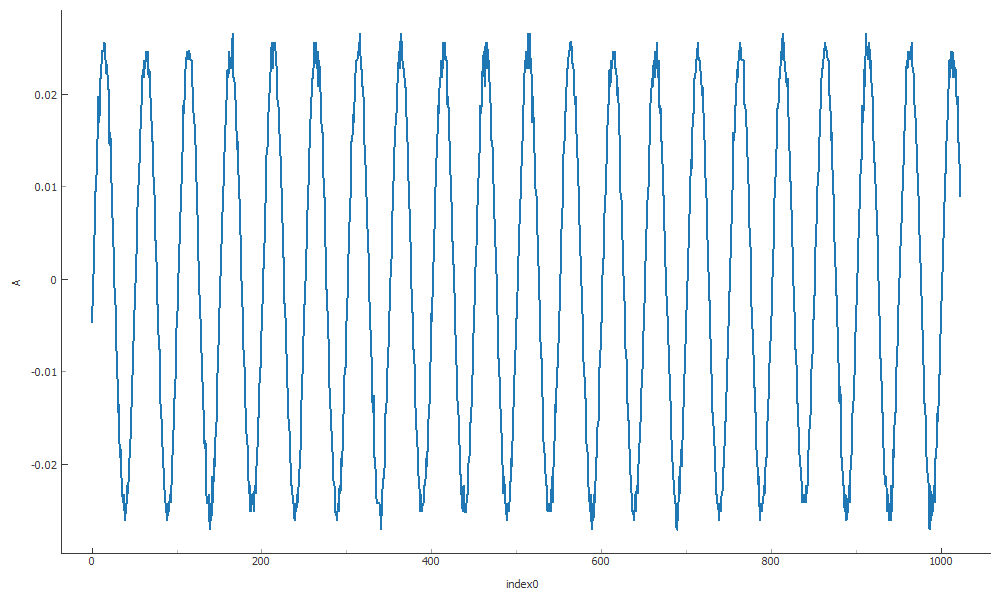

In [13]:
# Do this in as qcodes measurement (ie the same but makes a data set)
data2 = qc.Measure(basic_acq_controller.acquisition).run()
qc.QtPlot(data2.basic_acq_controller_A)

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-20/15-59-19_AlazarTest'
   <Type>   | <array_id>             | <array.name> | <array.shape>
   Setpoint | dummy_set              | dummy        | (5,)
   Measured | index0                 | index0       | (5, 1024)
   Measured | basic_acq_controller_A | A            | (5, 1024)
   Measured | basic_acq_controller_B | B            | (5, 1024)
started at 2017-01-20 15:59:23


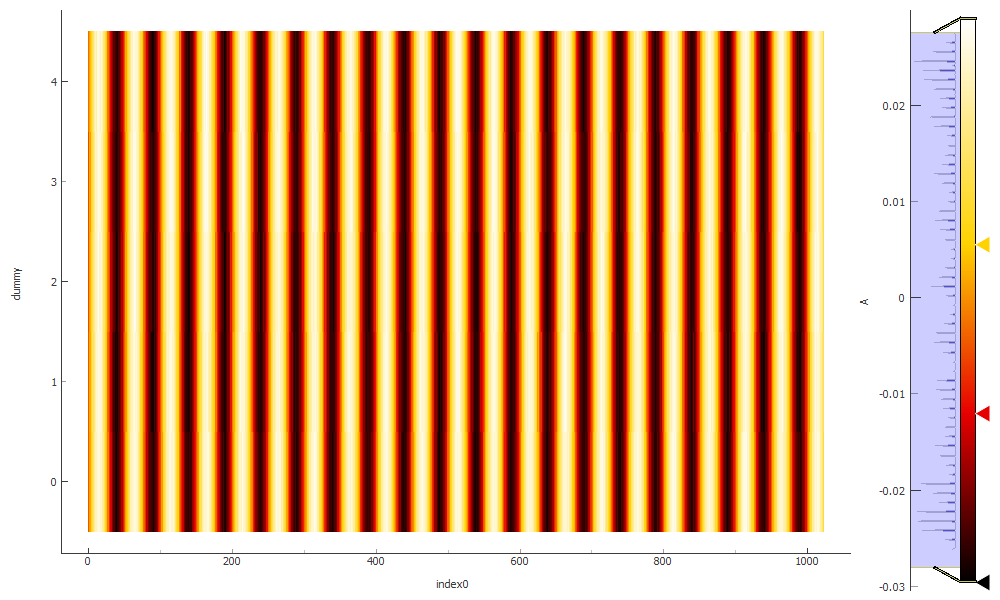

In [12]:
# Finally show that this instrument also works within a loop
dummy = parameter.ManualParameter(name="dummy")

data3 = qc.Loop(dummy[0:5:1]).each(basic_acq_controller.acquisition).run(name='AlazarTest')
qc.QtPlot(data3.basic_acq_controller_A)

### Samples Acquisition

This is the same as above except that it does some demodulation at the freqiencies specified

In [4]:
# make a list of the frequencies to demodulate at (nb these values can be changed later, if unset the default is [20e6])
# NB the number of demodulation frequencies cannot currently be changed once an acq controller is created, this sucks:
# lets have channels :)
demod_list = [95e6, 98e6, 100e6, 105e6]

In [5]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to and does the demodulation and signal processing
samp_acq_controller = samp_acq_contr.HD_Samples_Controller(name='samp_acq_controller', 
                                                           alazar_name='Alazar',
                                                          demod_freqs=demod_list)

In [6]:
# set integration time and delay (nb this replaces need to set samples_per record)
# if int_delay is unset it will default to a value corresponding to the about needed for the filter to work well
samp_acq_controller.int_time(2e-6)
samp_acq_controller.int_delay(2e-7)

In [ ]:
# to_default() can be used to reset int_delay to recommended filter value and int_time to use the maximum remaining time
# with the current number of samples_per_record
samp_acq_controller.int_time.to_default()
samp_acq_controller.int_delay.to_default()

In [7]:
# update_acquisition_kwargs now should not be used with samples_per_record but instead just for changing averaging values
samp_acq_controller.update_acquisition_kwargs(
                 records_per_buffer=1,
                 buffers_per_acquisition=1,
                 allocated_buffers=1
)

In [8]:
# demodulation _frequencies can be changed
samp_acq_controller.demod_freq_0(90e6)
samp_acq_controller.demod_freq_1(98e6)
samp_acq_controller.demod_freq_2(100e6)
samp_acq_controller.demod_freq_3(110e6)

In [9]:
# check the acquisition kwargs
samp_acq_controller.acquisition.acquisition_kwargs

{'allocated_buffers': 1,
 'buffers_per_acquisition': 1,
 'records_per_buffer': 1,
 'samples_per_record': 1120}

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-20/16-28-20'
   <Type>   | <array_id>                    | <array.name> | <array.shape>
   Measured | index1                        | index1       | (4, 1000)
   Measured | samp_acq_controller_magnitude | magnitude    | (4, 1000)
   Measured | samp_acq_controller_phase     | phase        | (4, 1000)
acquired at 2017-01-20 16:28:21


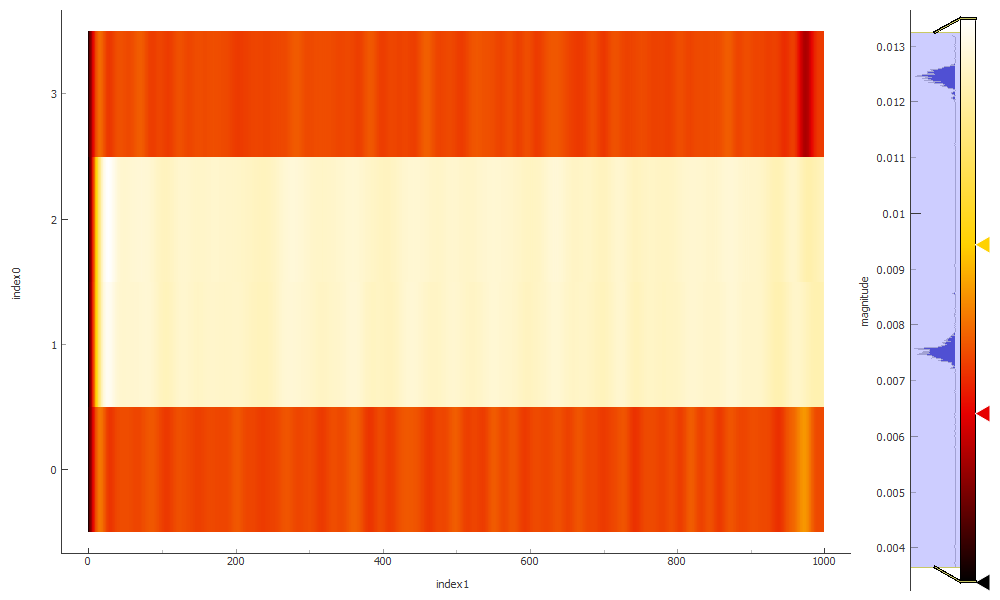

In [12]:
# as with basic...
# nb: index1 is actually the list demodulation frequency index but setpoints are ind of broken
data4 = qc.Measure(samp_acq_controller.acquisition).run()
qc.QtPlot(data4.samp_acq_controller_magnitude)

In [19]:
# in a loop

data5 = qc.Loop(samp_acq_controller.demod_freq_0.sweep(80e6, 120e6, 5e6)).each(
    samp_acq_controller.acquisition).run(name='AlazarTest')

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-20/16-31-16_AlazarTest'
   <Type>   | <array_id>                           | <array.name> | <array.shape>
   Setpoint | samp_acq_controller_demod_freq_0_set | demod_freq_0 | (9,)
   Measured | index1                               | index1       | (9, 4, 1000)
   Measured | samp_acq_controller_magnitude        | magnitude    | (9, 4, 1000)
   Measured | samp_acq_controller_phase            | phase        | (9, 4, 1000)
started at 2017-01-20 16:31:23


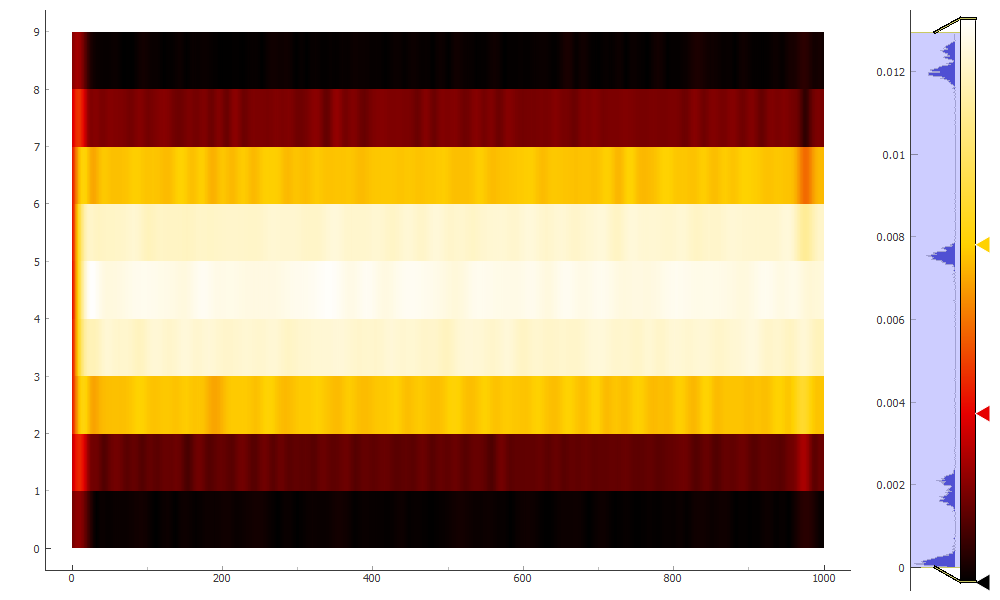

In [20]:
# plotting the measured demodulated amplitude (samples on y axis, different freqs on x), only looking at the one we swept
qc.QtPlot(data5.samp_acq_controller_magnitude[:, 0])

### Averaged Acquisition

As above but averages over the samples to give one magnitude per demodulation frequency

In [21]:
import qcodes.instrument_drivers.AlazarTech.ave_controller_test as ave_controller

demod_list = [95e6, 98e6, 100e6, 105e6]
ave_controller = ave_controller.HD_Controller(name='ave_controller', 
                                             alazar_name='Alazar1', 
                                             demod_freq = 5e6,)

SyntaxError: invalid syntax (ave_controller_test.py, line 75)

In [25]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
sing_contr.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=2560,
                 records_per_buffer=1,
                 buffers_per_acquisition=1,
                 allocated_buffers=1,
)

In [30]:
dummy = parameter.ManualParameter(name="dummy")
data6 = qc.Loop(dummy[0:5:1]).each(
    sing_contr.acquisition).run(name='AlazarTest')

DataSet:
   mode     = DataMode.LOCAL
   location = '2016-11-08/10-27-15_AlazarTest'
   <Type>   | <array_id>                  | <array.name> | <array.shape>
   Setpoint | dummy_set                   | dummy        | (5,)
   Measured | single_controller_magnitude | magnitude    | (5,)
   Measured | single_controller_phase     | phase        | (5,)
started at 2016-11-08 10:27:17


In [13]:
qc.QtPlot(data6.single_controller_phase)

In [ ]:
# Configure settings on Alazar card for sequencing mode (ie use aux i/o for triggering as well)
ats_inst.config(clock_source='EXTERNAL_CLOCK_10MHz_REF',
                sample_rate='10MHZ_REF_500MSPS',
                clock_edge='CLOCK_EDGE_RISING',
                decimation=1,
                coupling=['DC','DC'],
                channel_range=[.4,.4],
                impedance=[50,50],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=140,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='DC',
                external_trigger_range='ETR_2V5',
                trigger_delay=0,
                timeout_ticks=0,
                aux_io_mode='AUX_IN_TRIGGER_ENABLE', 
                aux_io_param='TRIG_SLOPE_POSITIVE'
)

In [11]:
import qcodes.instrument_drivers.AlazarTech.rec_controller as record_controller

rec_contr = record_controller.HD_Records_Controller(name='rec_controller', 
                                                      alazar_name='Alazar1', 
                                                      demod_freq = 5e6,
                                                      server_name="alazar_server")

a:\qcodes\qcodes\instrument\metaclass.py:37: UserWarning: Multiprocessing is in beta, use at own risk
  UserWarning)


In [12]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
rec_contr.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=20,
                 buffers_per_acquisition=1,
                 allocated_buffers=1,
)

<IPython.core.display.Javascript object>


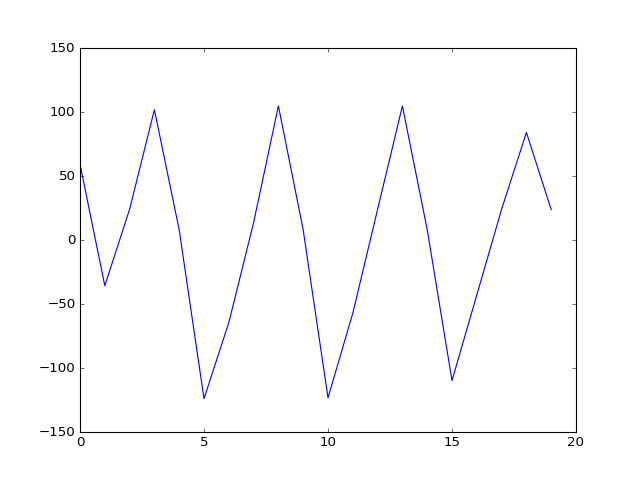

In [15]:
data7 = rec_contr.acquisition()
qc.MatPlot(data7[1])

In [16]:
dummy = parameter.ManualParameter(name="dummy")
data8 = qc.Loop(dummy[0:5:1]).each(
    rec_contr.acquisition).run(name='AlazarTest')

DataSet:
   mode     = DataMode.LOCAL
   location = '2016-11-08/11-29-47_AlazarTest'
   <Type>   | <array_id>               | <array.name> | <array.shape>
   Setpoint | dummy_set                | dummy        | (5,)
   Measured | record_num               | record_num   | (5, 20)
   Measured | rec_controller_magnitude | magnitude    | (5, 20)
   Measured | rec_controller_phase     | phase        | (5, 20)
started at 2016-11-08 11:29:49


In [17]:
qc.QtPlot(data8.rec_controller_magnitude)